In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib
import matplotlib.pyplot as plt
import missingno as msno
%matplotlib inline

import random
from nltk.corpus import names
import nltk
nltk.download("names")
from nltk import NaiveBayesClassifier

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import roc_auc_score,roc_curve
from sklearn.metrics import plot_confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from collections import Counter


from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

matplotlib.rc("xtick", labelsize = 14) 
matplotlib.rc("ytick", labelsize = 14)

from sklearn import set_config
set_config(print_changed_only = False)

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package names to /usr/share/nltk_data...
[nltk_data]   Package names is already up-to-date!


In [3]:
train_data = pd.read_csv("../input/spaceship-titanic/train.csv")
test_data = pd.read_csv("../input/spaceship-titanic/test.csv")

In [4]:
datasets = [train_data, test_data]
for data in datasets:
    data.rename(columns = {"PassengerId" : "id", "HomePlanet" : "home_planet", 
                   "CryoSleep" : "cryo_sleep", "Cabin" : "cabin", 
                   "Destination" : "destination", "Age" : "age",
                   "VIP" : "vip", "RoomService" : "room_service",
                   "FoodCourt" : "food_court", "ShoppingMall" : "shopping_mall",
                   "Spa" : "spa", "VRDeck" : "vr_deck", "Name" : "name",
                   "Transported" : "transported"}, inplace = True)

In [5]:
train_data["transported"] = train_data["transported"].replace(to_replace = [False, True], 
                                  value = ["No", "Yes"])
train_data["vip"] = train_data["vip"].replace(to_replace = [False, True], 
                                  value = ["No", "Yes"]).astype("object")
train_data["cryo_sleep"] = train_data["cryo_sleep"].replace(to_replace = [False, True], 
                                  value = ["No", "Yes"]).astype("object")

In [6]:
print("The number of rows in train data is {0}, and the number of columns in train data is {1}".
      format(train_data.shape[0], train_data.shape[1]))
      
print("The number of rows in test data is {0}, and the number of columns in test data is {1}".
      format(test_data.shape[0], test_data.shape[1]))

The number of rows in train data is 8693, and the number of columns in train data is 14
The number of rows in test data is 4277, and the number of columns in test data is 13


In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             8693 non-null   object 
 1   home_planet    8492 non-null   object 
 2   cryo_sleep     8476 non-null   object 
 3   cabin          8494 non-null   object 
 4   destination    8511 non-null   object 
 5   age            8514 non-null   float64
 6   vip            8490 non-null   object 
 7   room_service   8512 non-null   float64
 8   food_court     8510 non-null   float64
 9   shopping_mall  8485 non-null   float64
 10  spa            8510 non-null   float64
 11  vr_deck        8505 non-null   float64
 12  name           8493 non-null   object 
 13  transported    8693 non-null   object 
dtypes: float64(6), object(8)
memory usage: 950.9+ KB


In [8]:
train_data.isnull().sum()

id                 0
home_planet      201
cryo_sleep       217
cabin            199
destination      182
age              179
vip              203
room_service     181
food_court       183
shopping_mall    208
spa              183
vr_deck          188
name             200
transported        0
dtype: int64

In [9]:
numeric_data = [column for column in train_data.select_dtypes(["int", "float"])]
categoric_data = [column for column in train_data.select_dtypes(exclude = ["int", "float"])]
test_categoric_data = [column for column in test_data.select_dtypes(exclude = ["int", "float"])]

for col in numeric_data:
    train_data[col].fillna(train_data[col].median(), inplace = True)
    test_data[col].fillna(test_data[col].median(), inplace = True)
    
#replace missing values in each categorical column with the most frequent value
for col in categoric_data:
    train_data[col].fillna(train_data[col].value_counts().index[0], inplace = True)
for col in test_categoric_data:
    test_data[col].fillna(test_data[col].value_counts().index[0], inplace = True) 

In [10]:
train_data.isnull().sum().sum() + test_data.isnull().sum().sum()

0

In [11]:
train_data.corr()

,age,room_service,food_court,shopping_mall,spa,vr_deck
age,1.000000,0.068629,0.127390,0.033148,0.120946,0.099590
room_service,0.068629,1.000000,-0.015126,0.052337,0.009244,-0.018624
food_court,0.127390,-0.015126,1.000000,-0.013717,0.221468,0.224572
shopping_mall,0.033148,0.052337,-0.013717,1.000000,0.014542,-0.007849
spa,0.120946,0.009244,0.221468,0.014542,1.000000,0.147658
vr_deck,0.099590,-0.018624,0.224572,-0.007849,0.147658,1.000000


In [12]:
train_data.head()

,id,home_planet,cryo_sleep,cabin,destination,age,vip,room_service,food_court,shopping_mall,spa,vr_deck,name,transported
0,0001_01,Europa,No,B/0/P,TRAPPIST-1e,39.0,No,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,No
1,0002_01,Earth,No,F/0/S,TRAPPIST-1e,24.0,No,109.0,9.0,25.0,549.0,44.0,Juanna Vines,Yes
2,0003_01,Europa,No,A/0/S,TRAPPIST-1e,58.0,Yes,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,No
3,0003_02,Europa,No,A/0/S,TRAPPIST-1e,33.0,No,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,No
4,0004_01,Earth,No,F/1/S,TRAPPIST-1e,16.0,No,303.0,70.0,151.0,565.0,2.0,Willy Santantines,Yes


In [13]:
def outlier_detection_train(df, n, columns):
    rows = []
    will_drop_train = []
    for col in columns:
        Q1 = np.nanpercentile(df[col], 25)
        Q3 = np.nanpercentile(df[col], 75)
        IQR = Q3 - Q1
        outlier_point = 1.5 * IQR
        rows.extend(df[(df[col] < Q1 - outlier_point)|(df[col] > Q3 + outlier_point)].index)
    for r, c in Counter(rows).items():
        if c >= n: will_drop_train.append(r)
    return will_drop_train

In [14]:
will_drop_train = outlier_detection_train(train_data, 5 ,train_data.select_dtypes(["float", "int"]).columns)
train_data.drop(will_drop_train, inplace = True, axis = 0)

In [15]:
# Create 'deck' and 'side' features from 'cabin' column

train_data["deck"] = train_data["cabin"].apply(lambda x:str(x).split("/")[0])
test_data['deck'] = test_data['cabin'].apply(lambda x:str(x).split('/')[0])

train_data["side"] = train_data["cabin"].apply(lambda x: x.split("/")[2])
test_data["side"] = test_data["cabin"].apply(lambda x: x.split("/")[2])

In [16]:
# Financial situation of passengers

train_data["total_bill"] = train_data["room_service"] + train_data["food_court"] + train_data["shopping_mall"] + train_data["spa"] + train_data["vr_deck"] 
train_data["financial_situation"] = train_data["total_bill"].apply(lambda x: "poor" if x < 5000 else ("middle" if x>5000 and x<20000 else "rich"))

test_data["total_bill"] = test_data["room_service"] + test_data["food_court"] + test_data["shopping_mall"] + test_data["spa"] + test_data["vr_deck"] 
test_data["financial_situation"] = test_data["total_bill"].apply(lambda x: "poor" if x < 5000 else ("middle" if x>5000 and x<20000 else "rich"))

In [17]:
# create new feature ('in_group') from "PassengerID" variable

train_data["group_id"] = train_data["id"].apply(lambda x: x.split("_")[0])
test_data["group_id"] = test_data["id"].apply(lambda x: x.split("_")[0])
train_data["group_number"] = train_data["id"].apply(lambda x: x.split("_")[1])
test_data["group_number"] = test_data["id"].apply(lambda x: x.split("_")[1])

train_g = train_data[train_data["group_id"].duplicated()]["group_id"]
test_g = test_data[test_data["group_id"].duplicated()]["group_id"]
train_data["in_group"] = train_data["group_id"].apply(lambda x: x in train_g.values)
test_data["in_group"] = test_data["group_id"].apply(lambda x: x in test_g.values)

In [18]:
# FOR TRAIN_DATA

# get names from the 'name' columns of train_data

names_train_data = []
for n in train_data["name"]:
    a = n.split()
    names_train_data.append(a[0])

In [19]:
# define function to get last words from the name

def gender_features(word):
    return {'last_letter': word[-1]}

In [20]:
labeled_names = [(name, "female") for name in names.words("female.txt")] + [(name, "male") for name in names.words("male.txt")]
random.shuffle(labeled_names)

In [21]:
# use "gender_features" function to extract the features

featuresets = [(gender_features(n), gender) for (n, gender) in labeled_names]
classifier = NaiveBayesClassifier.train(featuresets)

In [22]:
names_gender = []
for i in names_train_data:
    names_gender.append(classifier.classify(gender_features(i)))

# create new column called 'gender'    
train_data["gender"] = names_gender


In [23]:
# FOR TEST_DATA


# get names from the 'name' columns of test_data

names_test_data = []
for n in test_data["name"]:
    a = n.split()
    names_test_data.append(a[0])

In [24]:
labeled_names = [(name, "male") for name in names.words("male.txt")] + [(name, "female") for name in names.words("female.txt")]
random.shuffle(labeled_names)

In [25]:
# use "gender_features" function to extract the features
featuresets = [(gender_features(n), gender) for (n, gender) in labeled_names]
classifier = NaiveBayesClassifier.train(featuresets)

In [26]:
names_gender = []
for i in names_test_data:
    names_gender.append(classifier.classify(gender_features(i)))
    
# create new column called 'gender'    
test_data["gender"] = names_gender

In [27]:
# Encoding the variables of train dataset
lbe = LabelEncoder()
lbe.fit_transform(train_data["transported"])
train_data["transported"] = lbe.fit_transform(train_data["transported"])

y = train_data["transported"]

train_data = train_data.drop(["id", "name", "cabin", "total_bill", "group_id", "group_number", "transported"], axis = 1)
x = pd.get_dummies(train_data, drop_first = True)

In [28]:
print(x.shape)
print(y.shape)

(8678, 24)
(8678,)


In [29]:
x.head()

,age,room_service,food_court,shopping_mall,spa,vr_deck,in_group,home_planet_Europa,home_planet_Mars,cryo_sleep_Yes,...,deck_C,deck_D,deck_E,deck_F,deck_G,deck_T,side_S,financial_situation_poor,financial_situation_rich,gender_male
0,39.0,0.0,0.0,0.0,0.0,0.0,False,1,0,0,...,0,0,0,0,0,0,0,1,0,1
1,24.0,109.0,9.0,25.0,549.0,44.0,False,0,0,0,...,0,0,0,1,0,0,1,1,0,0
2,58.0,43.0,3576.0,0.0,6715.0,49.0,True,1,0,0,...,0,0,0,0,0,0,1,0,0,1
3,33.0,0.0,1283.0,371.0,3329.0,193.0,True,1,0,0,...,0,0,0,0,0,0,1,0,0,1
4,16.0,303.0,70.0,151.0,565.0,2.0,False,0,0,0,...,0,0,0,1,0,0,1,1,0,0


In [30]:
y.head()

0    0
1    1
2    0
3    0
4    1
Name: transported, dtype: int64

In [31]:
# Splitting the train dataset into x_train (y_train) and x_test (y_test) sets

x_train, x_test, y_train, y_test = train_test_split(x, y,
                                                    test_size = 0.10,
                                                    shuffle = True,
                                                    random_state = 1)
print(x_train.shape)
print(x_test.shape)

(7810, 24)
(868, 24)


In [32]:
scaler = StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

In [33]:
#  XTREME GRADIENT BOOSTING (XGB)
# Build XGBoost model and search best hyperparameters with GridSearchCV method

'''

xgbc = XGBClassifier()

xgbc_params = {
        "gamma": [0.5, 1, 1.5],
        "subsample": [0.6, 0.8, 1.0],
        "colsample_bytree": [0.6, 0.8, 1.0],
        "max_depth": [3, 4, 5],
        "n_estimators": [100, 130, 150]
}

xgbc_cv_model = GridSearchCV(xgbc, xgbc_params, cv = 10, n_jobs = -1)
xgbc_cv_model.fit(x_train, y_train)

print("Best hyperparametres of the model: \n", xgbc_cv_model.best_params_)
'''

'\n\nxgbc = XGBClassifier()\n\nxgbc_params = {\n        "gamma": [0.5, 1, 1.5],\n        "subsample": [0.6, 0.8, 1.0],\n        "colsample_bytree": [0.6, 0.8, 1.0],\n        "max_depth": [3, 4, 5],\n        "n_estimators": [100, 130, 150]\n}\n\nxgbc_cv_model = GridSearchCV(xgbc, xgbc_params, cv = 10, n_jobs = -1)\nxgbc_cv_model.fit(x_train, y_train)\n\nprint("Best hyperparametres of the model: \n", xgbc_cv_model.best_params_)\n'

In [34]:
# Build XGB model with best hyperparameters
# get these hyperparameters with GridSearchCV method above

xgbc_tuned = XGBClassifier(gamma = 1.5,
                           subsample = 1.0,
                           max_depth = 5,
                           colsample_bytree = 1.0,
                           n_estimators = 100)
xgbc_tuned = xgbc_tuned.fit(x_train, y_train)

In [35]:
# Make initial prediction
y_pred = xgbc_tuned.predict(x_test)
accuracy_score(y_test, y_pred)

0.815668202764977

In [36]:
# Classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.81      0.82       436
           1       0.81      0.82      0.82       432

    accuracy                           0.82       868
   macro avg       0.82      0.82      0.82       868
weighted avg       0.82      0.82      0.82       868



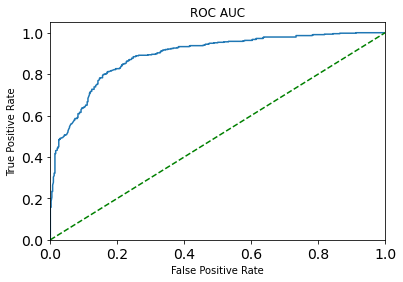

In [37]:
# ROC AUC
xgb_roc_auc = roc_auc_score(y_test, xgbc_tuned.predict(x_test))
fpr, tpr, thresholds = roc_curve(y_test, xgbc_tuned.predict_proba(x_test)[:,1])

plt.figure()
plt.plot(fpr, tpr, label = 'AUC (area = %0.2f)' % xgb_roc_auc)
plt.plot([0, 1], [0, 1],'g--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC')
plt.show()

In [38]:
# Build model with full data
xgbc_model_full = XGBClassifier(gamma = 1.5,
                           subsample = 1.0,
                           max_depth = 5,
                           colsample_bytree = 1.0,
                           n_estimators = 100)
xgbc_model_full = xgbc_model_full.fit(x, y)

**SUBMISSION PROCESS (on test.csv)**

In [39]:
# Change values of some variables
test_data["vip"] = test_data["vip"].replace(to_replace = [False, True],
                                  value = ["No", "Yes"]).astype("object")
test_data["cryo_sleep"] = test_data["cryo_sleep"].replace(to_replace = [False, True],
                                  value = ["No", "Yes"]).astype("object")

In [40]:
# Keep outside 'id' variable
PassengerID = test_data["id"]
PassengerID.head()


0    0013_01
1    0018_01
2    0019_01
3    0021_01
4    0023_01
Name: id, dtype: object

In [41]:
# One-hot encoding test_data
test_data = test_data.drop(["id", "total_bill", "cabin", "group_id", "group_number", "name"], axis = 1)
test_data = pd.get_dummies(test_data, drop_first = True)

In [42]:
# Make prediction
y_pred = pd.Series(xgbc_model_full.predict(test_data)).map({0:False, 1:True})

In [43]:
# Create submission file
submission = pd.DataFrame({"PassengerId": PassengerID.values, "Transported": y_pred})
submission.head()

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True


In [44]:
# Save submission file
from IPython.display import FileLink
submission.to_csv('submission.csv', index = False)
print("My competition submission: \n\n", submission)
FileLink('submission.csv')

My competition submission: 

      PassengerId  Transported
0        0013_01         True
1        0018_01        False
2        0019_01         True
3        0021_01         True
4        0023_01         True
...          ...          ...
4272     9266_02         True
4273     9269_01        False
4274     9271_01         True
4275     9273_01         True
4276     9277_01         True

[4277 rows x 2 columns]


/kaggle/working/submission.csv